<a href="https://colab.research.google.com/github/PhilHippo/MINDFUL-A-Lenskit-based-Recommender-System/blob/main/recsys_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [113]:
news = pd.read_csv('./training data/news.tsv',header=None,sep='\t')

In [114]:
news.columns=['News ID',
"Category",
"SubCategory",
"Title",
"Abstract",
"URL",
"Title Entities",
"Abstract Entities "]

In [115]:
c = news[['Category','SubCategory']].value_counts()

In [116]:
index=[]
for i in c.index:
    index.append(np.array(i))
index=np.array(index)

In [117]:
news_df=pd.DataFrame(columns = ['Category','Sub Category','Values'])
news_df['Category'] = index[:,0]
news_df['Sub Category'] = index[:,1]
news_df['Values'] = c.values

In [118]:
px.bar(data_frame=news_df,x='Category',y='Values',color='Sub Category')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


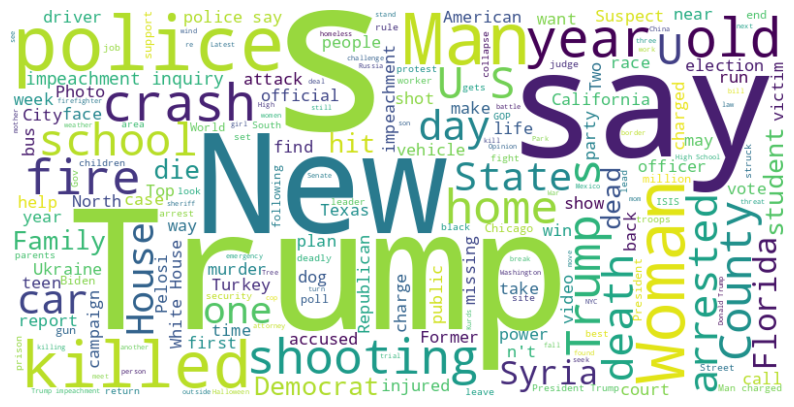

In [119]:
text=' '
for i in news[news['Category']=='news']['Title']:
    text += i + ' '

# Make the figure
nltk.download('punkt')
nltk.download('stopwords')


words = nltk.word_tokenize(text)
stop_words = set(stopwords.words('english'))
words = [word for word in words if word.lower() not in stop_words]

text = ' '.join(words)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

In [120]:
# Load data
behaviors = pd.read_csv('./training data/behaviors.tsv', delimiter='\t', header=None)
news = pd.read_csv('./training data/news.tsv', delimiter='\t', header=None)

# Naming columns
behaviors.columns = ["impression_id", "user_id", "time", "history", "impressions"]
news.columns = ["news_id", "category", "subcategory", "title", "abstract", "url", "title_entities", "abstract_entities"]

# Extracting clicked news from behaviors, this is a column of lists of the clicked news (tagget with 1) for each impression
behaviors['clicked_news'] = behaviors['impressions'].apply(lambda x: [imp.split('-')[0] for imp in x.split() if imp.split('-')[1] == '1'])

# Flattening the clicked news and associating with user_id, that means we divide the lists into one row for each clicked news
clicked_news = behaviors.explode('clicked_news')[['user_id', 'clicked_news']].dropna()

# Encoding user_id and news_id as categorical variables for memory and computation efficiency
clicked_news['user_id'] = clicked_news['user_id'].astype("category")
clicked_news['clicked_news'] = clicked_news['clicked_news'].astype("category")


In [121]:
#Here we make a user-item interaction matrix
# Creating a sparse matrix, this is only composed by positive interactions (all ones) since we'll use KNN and it's way faster
#(i, j) i is the item index in rows, j is the user index in columns
interaction_matrix = csr_matrix(
    (
        np.ones(clicked_news.shape[0]),
        (
            clicked_news['clicked_news'].cat.codes.copy(),
            clicked_news['user_id'].cat.codes.copy()
        )
    )
)

In [122]:
# Ensure we're working with unique user and item IDs
unique_users = clicked_news['user_id'].drop_duplicates().reset_index(drop=True)
unique_items = clicked_news['clicked_news'].drop_duplicates().reset_index(drop=True)

# Create mappings from IDs to indices
user_to_idx = pd.Series(data=np.arange(len(unique_users)), index=unique_users)
item_to_idx = pd.Series(data=np.arange(len(unique_items)), index=unique_items)

# Create mappings from indices to IDs
idx_to_user = pd.Series(data=unique_users, index=np.arange(len(unique_users)))
idx_to_item = pd.Series(data=unique_items, index=np.arange(len(unique_items)))

In [123]:
# Compute Item Similarity using k-Nearest Neighbors
# Initialize the model, we choose cosine similarity due to the high dimensionality and sparsity of user interactions
# tipically a user interacts only with a small fraction of the news

model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

# Fit the model
model_knn.fit(interaction_matrix.T)  # .T transposes the matrix, as we want to find similar items, not users

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [124]:
print(interaction_matrix)

  (0, 6873)	1.0
  (1, 1292)	1.0
  (1, 3540)	1.0
  (2, 250)	1.0
  (2, 962)	1.0
  (2, 1869)	1.0
  (2, 3929)	1.0
  (3, 4912)	1.0
  (4, 1680)	1.0
  (4, 3011)	1.0
  (4, 3018)	1.0
  (4, 3047)	1.0
  (4, 4568)	1.0
  (4, 6863)	1.0
  (5, 16)	1.0
  (5, 6230)	1.0
  (5, 6408)	1.0
  (6, 3868)	1.0
  (7, 250)	1.0
  (7, 509)	1.0
  (7, 1313)	1.0
  (7, 2060)	1.0
  (7, 2486)	1.0
  (7, 7403)	1.0
  (8, 3624)	1.0
  :	:
  (2520, 1355)	1.0
  (2521, 734)	1.0
  (2522, 496)	1.0
  (2522, 1983)	1.0
  (2522, 2358)	1.0
  (2522, 3064)	1.0
  (2522, 3314)	1.0
  (2522, 3796)	1.0
  (2522, 4275)	1.0
  (2522, 5517)	1.0
  (2522, 6686)	1.0
  (2522, 7645)	1.0
  (2523, 1191)	1.0
  (2523, 2201)	1.0
  (2523, 2825)	1.0
  (2523, 3705)	1.0
  (2523, 6398)	1.0
  (2523, 6695)	1.0
  (2524, 2502)	1.0
  (2525, 5858)	1.0
  (2526, 7853)	1.0
  (2527, 4700)	1.0
  (2528, 1336)	1.0
  (2529, 7758)	1.0
  (2530, 7148)	1.0


In [111]:
#there's a bug in the construction of similar_items

def recommend(user_id, interaction_matrix, model_knn, k=5):
    """
    Recommends k news articles for a given user.

    Parameters:
        user_id (str): The ID of the user.
        interaction_matrix (csr_matrix): The user-item interaction matrix.
        model_knn (NearestNeighbors): The k-NN model.
        k (int): The number of recommendations to generate.

    Returns:
        list: k recommended news article IDs.
    """
    # Find the indices of items the user has interacted with
    interacted_indices = interaction_matrix[:, user_to_idx[user_id]].nonzero()[0]

    # Find similar items for each item the user has interacted with
    similar_items = set()  # Using a set to avoid duplicate items
    for item_idx in interacted_indices:
        # Ensure the input to kneighbors is 2D: (1, n_users)
        item_vector = interaction_matrix.T[item_idx].reshape(1, -1)

        # Find similar items
        _, similar_item_indices = model_knn.kneighbors(item_vector, n_neighbors=k+1)

        # Add the similar items to the set, excluding items the user has interacted with
        similar_items.update(idx for idx in similar_item_indices.flatten() if idx not in interacted_indices)

    # Recommend top-k items
    # Convert item indices to item IDs and select top-k items
    recommended_item_ids = [idx_to_item.get(idx, "Unknown") for idx in similar_items][:k]

    return recommended_item_ids


In [125]:
top_users = behaviors['user_id'].value_counts().head(n=10)  # n is the number of top users you want to retrieve

print(top_users)

U32594    6
U39770    6
U31631    5
U15740    4
U77964    4
U86724    4
U89585    4
U12508    4
U47892    4
U75347    4
Name: user_id, dtype: int64


In [110]:
recommended_articles = recommend('U32594', interaction_matrix, model_knn, k=5)

Max index in similar items: 6322
Max index in idx_to_item: 2530


KeyError: ignored

In [126]:
interacted_indices = interaction_matrix[:, user_to_idx['U32594']].nonzero()[0]
print(interaction_matrix[interacted_indices[0]].shape)

NameError: ignored